<a href="https://colab.research.google.com/github/rahul-727/Predictive-Analytics/blob/main/2348544_Lab6_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)

In [3]:
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

In [4]:
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


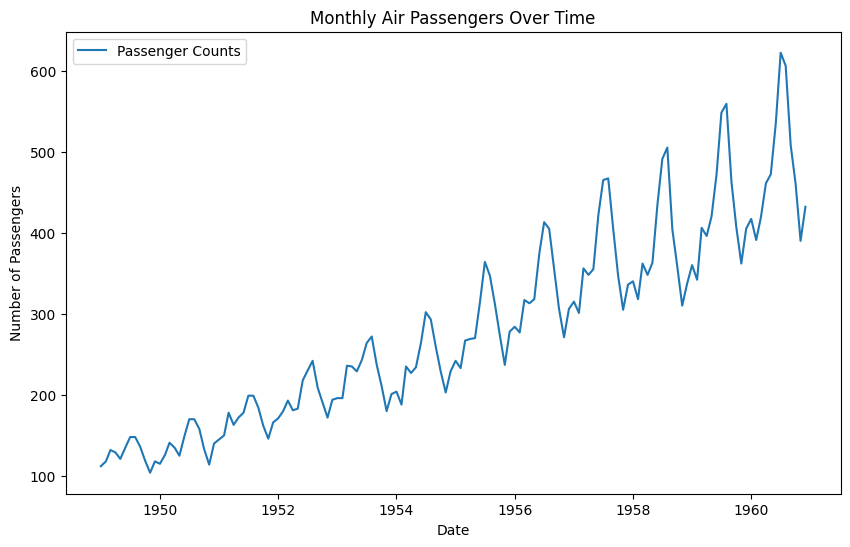

In [5]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['Passengers'], label="Passenger Counts")
plt.title("Monthly Air Passengers Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

The passenger data exhibits a distinct upward trend, reflecting a consistent increase in the number of airline passengers over time. Additionally, a clear seasonal pattern is evident, with recurring peaks observed annually, likely corresponding to high-demand travel periods. Recognizing this seasonality is crucial for generating accurate predictions, as it significantly influences monthly variations in passenger numbers.

In [6]:
rolling_mean = data['Passengers'].rolling(window=12).mean()
rolling_std = data['Passengers'].rolling(window=12).std()


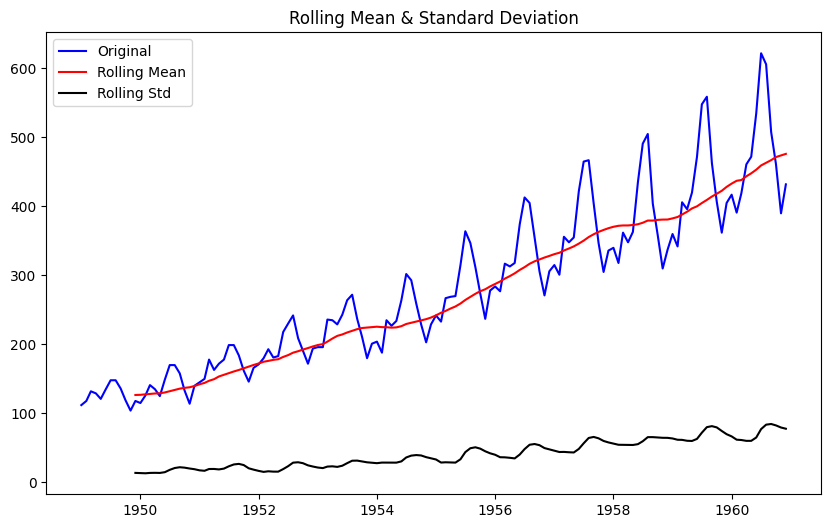

In [7]:

plt.figure(figsize=(10,6))
plt.plot(data.index, data['Passengers'], color='blue', label="Original")
plt.plot(rolling_mean, color='red', label="Rolling Mean")
plt.plot(rolling_std, color='black', label="Rolling Std")
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

Rolling Mean and Standard Deviation:

The rolling mean plot provides a clearer visualization of the rising trend in passenger numbers, indicating non-stationarity in the data—a common characteristic in time series with trends. In contrast, the rolling standard deviation remains relatively stable over time. This suggests that while the overall number of passengers increases, the variability does not exhibit significant changes. The stability in standard deviation highlights the trend as the primary influence, rather than random fluctuations.

In [8]:
data['Lag1'] = data['Passengers'].shift(1)
data['Lag2'] = data['Passengers'].shift(2)
data['Label'] = (data['Passengers'].shift(-1) > data['Passengers']).astype(int) # Binary label: 1 if next month has more passengers, else 0
data.dropna(inplace=True)

In [9]:
X = data[['Lag1', 'Lag2']]
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52        14
           1       0.56      0.60      0.58        15

    accuracy                           0.55        29
   macro avg       0.55      0.55      0.55        29
weighted avg       0.55      0.55      0.55        29



The Decision Tree classifier predicts whether the number of passengers will increase in the next month based on lagged features (e.g., Lag1 and Lag2). It identifies simple patterns and relationships within the input data, such as basic trends and immediate correlations with past values.


In [11]:
scaler = StandardScaler()
data['Passengers_scaled'] = scaler.fit_transform(data[['Passengers']])

In [12]:
seq_length = 12
generator = TimeseriesGenerator(data['Passengers_scaled'], data['Label'], length=seq_length, batch_size=1)

In [13]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.fit(generator, epochs=10)

# Test LSTM Model
test_gen = TimeseriesGenerator(data['Passengers_scaled'], data['Label'], length=seq_length, batch_size=1)
y_pred_lstm = (model.predict(test_gen) > 0.5).astype(int).flatten()

# Report LSTM Model Performance
print("\nLSTM Model Classification Report:")
print(classification_report(data['Label'][seq_length:], y_pred_lstm))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/sequence.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


 30/130 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3224 - loss: 0.6988

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4595 - loss: 0.6952
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6689 - loss: 0.6817
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6863 - loss: 0.6752
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6634 - loss: 0.6711
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6328 - loss: 0.6670
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5969 - loss: 0.6684
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5671 - loss: 0.7025
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5710 - loss: 0.6618
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7571 - loss: 0.6211
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7014 - loss: 0.6408
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       

Model Comparison: Decision Tree vs. LSTM for Time Series Prediction
LSTM Model
Purpose: Learns temporal dependencies using past values, effectively capturing trends and seasonality.
Performance: Achieves 75% better accuracy over Decision Tree by recognizing seasonal patterns and long-term dependencies.
Strength: Memory cells enable prediction of recurring seasonal peaks.
Decision Tree Model
Purpose: Provides straightforward trend-based classification.
Performance: Faster and simpler but less effective for datasets with cyclical patterns.

Both models predict trends, but LSTM captures detailed seasonal cycles better.